In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
import nltk
import Levenshtein

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ali/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
ALPHA = 0.5

In [4]:
def calculate_levenshtein_accuracy(true_sentence, generated_sentence):
    distance = Levenshtein.distance(true_sentence, generated_sentence)
    max_len = max(len(true_sentence), len(generated_sentence))
    return 1 - (distance / max_len)

def calculate_bleu_score(true_sentence, generated_sentence):
    # Use a smoothing function to avoid BLEU score being zero
    smoothing_function = SmoothingFunction().method1
    return sentence_bleu(
        [true_sentence.split()], 
        generated_sentence.split(), 
        smoothing_function=smoothing_function
    )

def calculate_rouge_scores(true_sentence, generated_sentence):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(true_sentence, generated_sentence)
    rouge_scores = {
        "rouge1": scores['rouge1'].fmeasure,
        "rouge2": scores['rouge2'].fmeasure,
        "rougeL": scores['rougeL'].fmeasure
    }
    return list(rouge_scores.values())

def calculate_meteor_score(true_sentence, generated_sentence):
    # Tokenize sentences
    reference_tokens = true_sentence.split()
    generated_tokens = generated_sentence.split()
    # Calculate METEOR score
    return meteor_score([reference_tokens], generated_tokens)

def combined_score(levenshtein_accuracy, bleu_score, alpha=ALPHA):
    return alpha * levenshtein_accuracy + (1 - alpha) * bleu_score

In [5]:
# test rouge
true_sentence = "The quick brown fox jumps over the lazy dog"
generated_sentence = "The quick brown fox jumps over the lazy dog"
rouge_scores = calculate_rouge_scores(true_sentence, generated_sentence)
print(rouge_scores)

[1.0, 1.0, 1.0]


In [6]:
model_map = {
    'base': 'O-CoAtNet',
    'llama3_2_1b': 'LLAMA-3.2-1B',
    'llama3_2_3b': 'LLAMA-3.2-3B',
    'llama3_1_8b': 'LLAMA-3.1-8B',
    'gpt-4o': 'GPT-4o',
    'echocrypt': 'Fine-tuned LLAMA-3.2-3B',
}

In [7]:
main_dir = '.'

In [14]:
# Data holder for plotting
results = []
file_counter = 0

for model_dir in os.listdir(main_dir):
    model_path = os.path.join(main_dir, model_dir)
    if os.path.isdir(model_path):
        for csv_file in os.listdir(model_path):
            if csv_file.endswith('.csv'):
                csv_path = os.path.join(model_path, csv_file)
                df = pd.read_csv(csv_path)
                nf = float(csv_file.replace('.csv', '').replace('noise_', ''))
                model_name = model_dir
                # Calculate average accuracy for each CSV (noise factor)
                lev_accuracies = []
                bleu_accuracies = []
                for _, row in df.iterrows():
                    true_sentence = row['True Sentence']
                    predicted_sentence = row['Predicted Sentence']
                    llm_sentence = row['LLM Sentence']
                    
                    base_leven = calculate_levenshtein_accuracy(true_sentence, predicted_sentence)
                    base_bleu = calculate_bleu_score(true_sentence, predicted_sentence)
                    base_combined = combined_score(base_leven, base_bleu)
                    base_meteor = calculate_meteor_score(true_sentence, predicted_sentence)
                    base_rouge1, base_rouge2, base_rougeL = calculate_rouge_scores(true_sentence, predicted_sentence)
                    
                    llm_leven = calculate_levenshtein_accuracy(true_sentence, llm_sentence)
                    llm_bleu = calculate_bleu_score(true_sentence, llm_sentence)
                    llm_combined = combined_score(llm_leven, llm_bleu)
                    llm_meteor = calculate_meteor_score(true_sentence, llm_sentence)
                    llm_rouge1, llm_rouge2, llm_rougeL = calculate_rouge_scores(true_sentence, llm_sentence)
                    
                    if file_counter < 3:
                        results.append({
                            'Model': model_map['base'], # CoAtNet
                            'Noise Factor': nf,
                            'Levenshtein Accuracy': base_leven,
                            'BLEU Accuracy': base_bleu,
                            'Meteor Score': base_meteor,
                            'Rouge-1': base_rouge1,
                            'Rouge-2': base_rouge2,
                            'Rouge-L': base_rougeL,
                            'Adjusted Accuracy': base_combined,
                        })
                    
                    results.append({
                        'Model': model_map[model_name], # LLM
                        'Noise Factor': nf,
                        'Levenshtein Accuracy': llm_leven,
                        'BLEU Accuracy': llm_bleu,
                        'Meteor Score': llm_meteor,
                        'Rouge-1': llm_rouge1,
                        'Rouge-2': llm_rouge2,
                        'Rouge-L': llm_rougeL,
                        'Adjusted Accuracy': llm_combined,
                    })
        file_counter += 3


KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame(results)
# re-order models based on model_map.values()
results_df['Model'] = pd.Categorical(results_df['Model'], model_map.values())
# results_df['Noise Factor'] = results_df['Noise Factor'].astype(str)
results_df

,Model,Noise Factor,Levenshtein Accuracy,BLEU Accuracy,Meteor Score,Rouge-1,Rouge-2,Rouge-L,Adjusted Accuracy
0,O-CoAtNet,0.024,0.826923,0.031098,0.198506,0.258065,0.068966,0.258065,0.429010
1,LLAMA-3.2-1B,0.024,1.000000,1.000000,0.999878,1.000000,1.000000,1.000000,1.000000
2,O-CoAtNet,0.024,0.870968,0.205957,0.456614,0.518519,0.240000,0.518519,0.538462
3,LLAMA-3.2-1B,0.024,0.021505,0.000000,0.000000,0.000000,0.000000,0.000000,0.010753
4,O-CoAtNet,0.024,0.841270,0.053077,0.315625,0.400000,0.111111,0.400000,0.447173
...,...,...,...,...,...,...,...,...,...
17995,LLAMA-3.2-3B,0.012,0.907407,0.643459,0.841270,0.857143,0.666667,0.857143,0.775433
17996,LLAMA-3.2-3B,0.012,0.932432,0.701688,0.905455,0.909091,0.800000,0.909091,0.817060
17997,LLAMA-3.2-3B,0.012,0.942308,0.467138,0.778906,0.800000,0.555556,0.800000,0.704723
17998,LLAMA-3.2-3B,0.012,0.972603,0.880112,0.899383,0.900000,0.888889,0.900000,0.926357


In [ ]:

mean_df = results_df.groupby(['Model', 'Noise Factor']).mean().reset_index()
std_df = results_df.groupby(['Model', 'Noise Factor']).std().reset_index()

/tmp/ipykernel_1255872/2869310711.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = results_df.groupby(['Model', 'Noise Factor']).mean().reset_index()
/tmp/ipykernel_1255872/2869310711.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_df = results_df.groupby(['Model', 'Noise Factor']).std().reset_index()


In [ ]:
mean_df.to_excel('mean.xlsx', index=False)
std_df.to_excel('std.xlsx', index=False)

In [12]:
mean_df

,Model,Noise Factor,Levenshtein Accuracy,BLEU Accuracy,Meteor Score,Rouge-1,Rouge-2,Rouge-L,Adjusted Accuracy
0,O-CoAtNet,0.012,0.954934,0.382687,0.640261,0.690445,0.497464,0.690445,0.668811
1,O-CoAtNet,0.024,0.849667,0.078292,0.285578,0.373621,0.131358,0.373621,0.463979
2,O-CoAtNet,0.060,0.666634,0.020829,0.082084,0.141094,0.017019,0.141094,0.343732
3,LLAMA-3.2-1B,0.012,0.906951,0.684136,0.829666,0.843997,0.753865,0.843509,0.795543
4,LLAMA-3.2-1B,0.024,0.755460,0.272778,0.504091,0.552086,0.361365,0.550102,0.514119
5,LLAMA-3.2-1B,0.060,0.558232,0.041068,0.137256,0.195977,0.058535,0.194066,0.299650
6,LLAMA-3.2-3B,0.012,0.969745,0.862792,0.941060,0.943644,0.898633,0.943417,0.916268
7,LLAMA-3.2-3B,0.024,0.844219,0.541753,0.751380,0.777061,0.629015,0.776414,0.692986
8,LLAMA-3.2-3B,0.060,0.517069,0.117851,0.343862,0.405937,0.190513,0.399777,0.317460
9,LLAMA-3.1-8B,0.012,0.978610,0.909638,0.963748,0.964181,0.931836,0.962988,0.944124


In [13]:
df = mean_df.copy()
df2 = std_df.copy()

# Map Noise Factor to corresponding levels
noise_levels = {0.012: "Low", 0.024: "Mid", 0.06: "High"}
bold_model = "GPT-4o"
df["Noise Level"] = df["Noise Factor"].map(noise_levels)
df2["Noise Level"] = df2["Noise Factor"].map(noise_levels)

# Generate LaTeX table rows
def generate_latex_rows(df, std_df, metric_columns):
    latex_rows = []
    for metric in metric_columns:
        for noise_level in ["Low", "Mid", "High"]:
            subset = df[(df["Noise Level"] == noise_level)]
            subset_std = std_df[(std_df["Noise Level"] == noise_level)]
           
            row = f"        {metric} ({noise_level}) & " + " & ".join(
                f"{mean:.3f} $\\pm$ {std:.3f}" for mean, std in zip(subset[metric], subset_std[metric])
            ) + " \\\\"
            latex_rows.append(row)
        latex_rows.append("\midrule")
    return "\n".join(latex_rows)

# Specify metric columns
metric_columns = ["BLEU Accuracy", "Meteor Score", "Rouge-1", "Rouge-2", "Rouge-L"]

# Generate LaTeX rows for the specified metrics
latex_rows = generate_latex_rows(df, df2, metric_columns)

# Print the rows
print(latex_rows)


        BLEU Accuracy (Low) & 0.383 $\pm$ 0.249 & 0.684 $\pm$ 0.294 & 0.863 $\pm$ 0.183 & 0.910 $\pm$ 0.159 & 0.975 $\pm$ 0.075 & 0.977 $\pm$ 0.073 \\
        BLEU Accuracy (Mid) & 0.078 $\pm$ 0.091 & 0.273 $\pm$ 0.268 & 0.542 $\pm$ 0.282 & 0.681 $\pm$ 0.258 & 0.916 $\pm$ 0.120 & 0.908 $\pm$ 0.156 \\
        BLEU Accuracy (High) & 0.021 $\pm$ 0.023 & 0.041 $\pm$ 0.083 & 0.118 $\pm$ 0.151 & 0.189 $\pm$ 0.196 & 0.638 $\pm$ 0.287 & 0.623 $\pm$ 0.302 \\
\midrule
        Meteor Score (Low) & 0.640 $\pm$ 0.190 & 0.830 $\pm$ 0.213 & 0.941 $\pm$ 0.084 & 0.964 $\pm$ 0.070 & 0.988 $\pm$ 0.032 & 0.990 $\pm$ 0.032 \\
        Meteor Score (Mid) & 0.286 $\pm$ 0.162 & 0.504 $\pm$ 0.273 & 0.751 $\pm$ 0.184 & 0.846 $\pm$ 0.143 & 0.958 $\pm$ 0.057 & 0.960 $\pm$ 0.073 \\
        Meteor Score (High) & 0.082 $\pm$ 0.085 & 0.137 $\pm$ 0.159 & 0.344 $\pm$ 0.211 & 0.454 $\pm$ 0.219 & 0.804 $\pm$ 0.189 & 0.807 $\pm$ 0.191 \\
\midrule
        Rouge-1 (Low) & 0.690 $\pm$ 0.157 & 0.844 $\pm$ 0.194 & 0.944 $\pm$ 0

['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'Fine-tuned LLAMA-3.2-3B']
Categories (6, object): ['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'Fine-tuned LLAMA-3.2-3B']


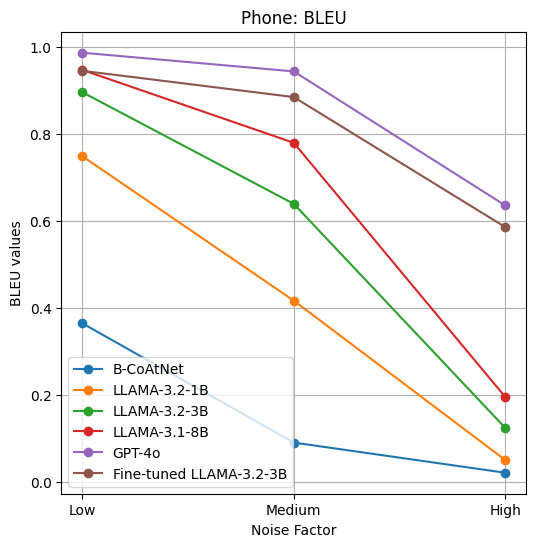

In [13]:
import math 

models = mean_df["Model"].unique()
print(models)
plt.figure(figsize=(6, 6))

for model in models:
    mean_subset = mean_df[mean_df["Model"] == model]
    std_subset = std_df[std_df["Model"] == model]
    
    # Extracting values and ensuring alignment
    x_values = mean_subset["Noise Factor"].values
    y_mean = mean_subset["BLEU Accuracy"].values
    # y_std = std_subset["BLEU Accuracy"].values 
    y_std = 0
    
    # Calculating bounds
    lower_bound = y_mean - y_std
    upper_bound = y_mean + y_std
    
    # Plotting mean line
    plt.plot(x_values, y_mean, marker='o', label=model)
    
    # Adding shaded area
    plt.fill_between(x_values, lower_bound, upper_bound, alpha=0.2)

plt.title("Phone: BLEU")
plt.xlabel("Noise Factor")
plt.xticks([1.0, 1.5, 2.0], labels=["Low", "Medium", "High"])
plt.ylabel("BLEU values")
plt.legend()
plt.grid(True)
plt.show()

['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'Fine-tuned LLAMA-3.2-3B']
Categories (6, object): ['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'Fine-tuned LLAMA-3.2-3B']


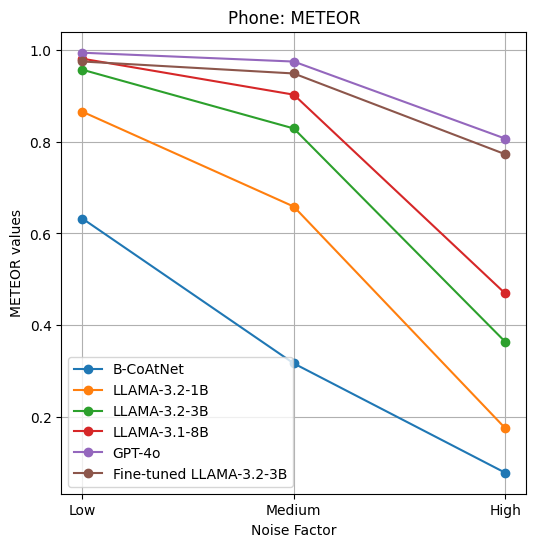

In [14]:
import math 

models = mean_df["Model"].unique()
print(models)
plt.figure(figsize=(6, 6))

for model in models:
    mean_subset = mean_df[mean_df["Model"] == model]
    std_subset = std_df[std_df["Model"] == model]
    
    # Extracting values and ensuring alignment
    x_values = mean_subset["Noise Factor"].values
    y_mean = mean_subset["Meteor Score"].values
    # y_std = std_subset["BLEU Accuracy"].values 
    y_std = 0
    
    # Calculating bounds
    lower_bound = y_mean - y_std
    upper_bound = y_mean + y_std
    
    # Plotting mean line
    plt.plot(x_values, y_mean, marker='o', label=model)
    
    # Adding shaded area
    plt.fill_between(x_values, lower_bound, upper_bound, alpha=0.2)

plt.title("Phone: METEOR")
plt.xlabel("Noise Factor")
plt.xticks([1.0, 1.5, 2.0], labels=["Low", "Medium", "High"])
plt.ylabel("METEOR values")
plt.legend()
plt.grid(True)
plt.show()

['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'Fine-tuned LLAMA-3.2-3B']
Categories (6, object): ['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'Fine-tuned LLAMA-3.2-3B']


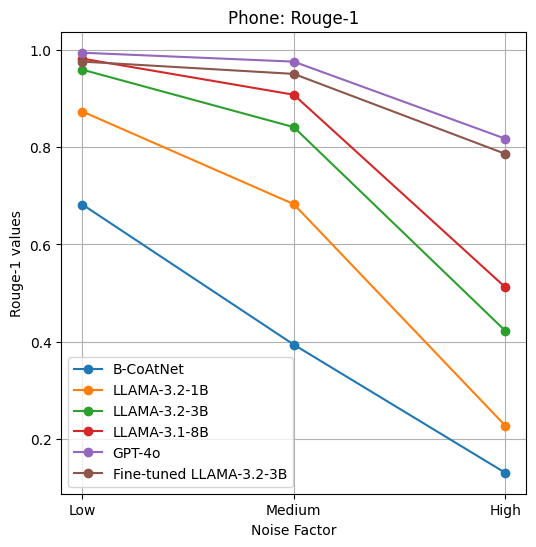

In [15]:
import math 

models = mean_df["Model"].unique()
print(models)
plt.figure(figsize=(6, 6))

for model in models:
    mean_subset = mean_df[mean_df["Model"] == model]
    std_subset = std_df[std_df["Model"] == model]
    
    # Extracting values and ensuring alignment
    x_values = mean_subset["Noise Factor"].values
    y_mean = mean_subset["Rouge-1"].values
    # y_std = std_subset["BLEU Accuracy"].values 
    y_std = 0
    
    # Calculating bounds
    lower_bound = y_mean - y_std
    upper_bound = y_mean + y_std
    
    # Plotting mean line
    plt.plot(x_values, y_mean, marker='o', label=model)
    
    # Adding shaded area
    plt.fill_between(x_values, lower_bound, upper_bound, alpha=0.2)

plt.title("Phone: Rouge-1")
plt.xlabel("Noise Factor")
plt.xticks([1.0, 1.5, 2.0], labels=["Low", "Medium", "High"])
plt.ylabel("Rouge-1 values")
plt.legend()
plt.grid(True)
plt.show()

['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'Fine-tuned LLAMA-3.2-3B']
Categories (6, object): ['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'Fine-tuned LLAMA-3.2-3B']


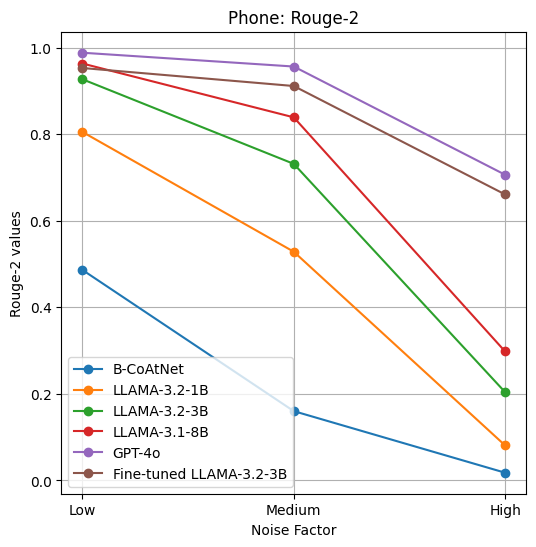

In [16]:
import math 

models = mean_df["Model"].unique()
print(models)
plt.figure(figsize=(6, 6))

for model in models:
    mean_subset = mean_df[mean_df["Model"] == model]
    std_subset = std_df[std_df["Model"] == model]
    
    # Extracting values and ensuring alignment
    x_values = mean_subset["Noise Factor"].values
    y_mean = mean_subset["Rouge-2"].values
    # y_std = std_subset["BLEU Accuracy"].values 
    y_std = 0
    
    # Calculating bounds
    lower_bound = y_mean - y_std
    upper_bound = y_mean + y_std
    
    # Plotting mean line
    plt.plot(x_values, y_mean, marker='o', label=model)
    
    # Adding shaded area
    plt.fill_between(x_values, lower_bound, upper_bound, alpha=0.2)

plt.title("Phone: Rouge-2")
plt.xlabel("Noise Factor")
plt.xticks([1.0, 1.5, 2.0], labels=["Low", "Medium", "High"])
plt.ylabel("Rouge-2 values")
plt.legend()
plt.grid(True)
plt.show()

['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'Fine-tuned LLAMA-3.2-3B']
Categories (6, object): ['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'Fine-tuned LLAMA-3.2-3B']


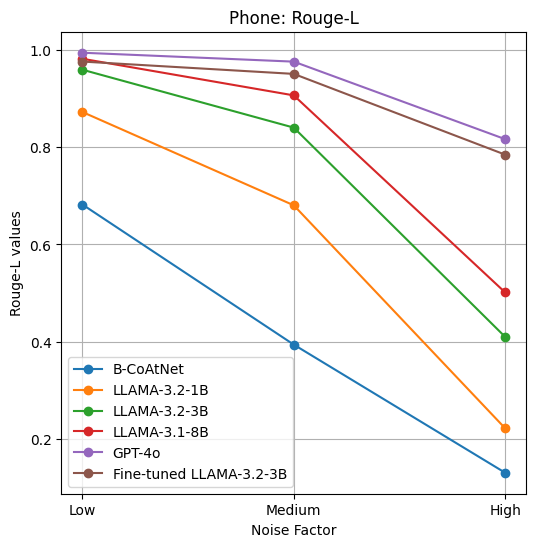

In [17]:
import math 

models = mean_df["Model"].unique()
print(models)
plt.figure(figsize=(6, 6))

for model in models:
    mean_subset = mean_df[mean_df["Model"] == model]
    std_subset = std_df[std_df["Model"] == model]
    
    # Extracting values and ensuring alignment
    x_values = mean_subset["Noise Factor"].values
    y_mean = mean_subset["Rouge-L"].values
    # y_std = std_subset["BLEU Accuracy"].values 
    y_std = 0
    
    # Calculating bounds
    lower_bound = y_mean - y_std
    upper_bound = y_mean + y_std
    
    # Plotting mean line
    plt.plot(x_values, y_mean, marker='o', label=model)
    
    # Adding shaded area
    plt.fill_between(x_values, lower_bound, upper_bound, alpha=0.2)

plt.title("Phone: Rouge-L")
plt.xlabel("Noise Factor")
plt.xticks([1.0, 1.5, 2.0], labels=["Low", "Medium", "High"])
plt.ylabel("Rouge-L values")
plt.legend()
plt.grid(True)
plt.show()

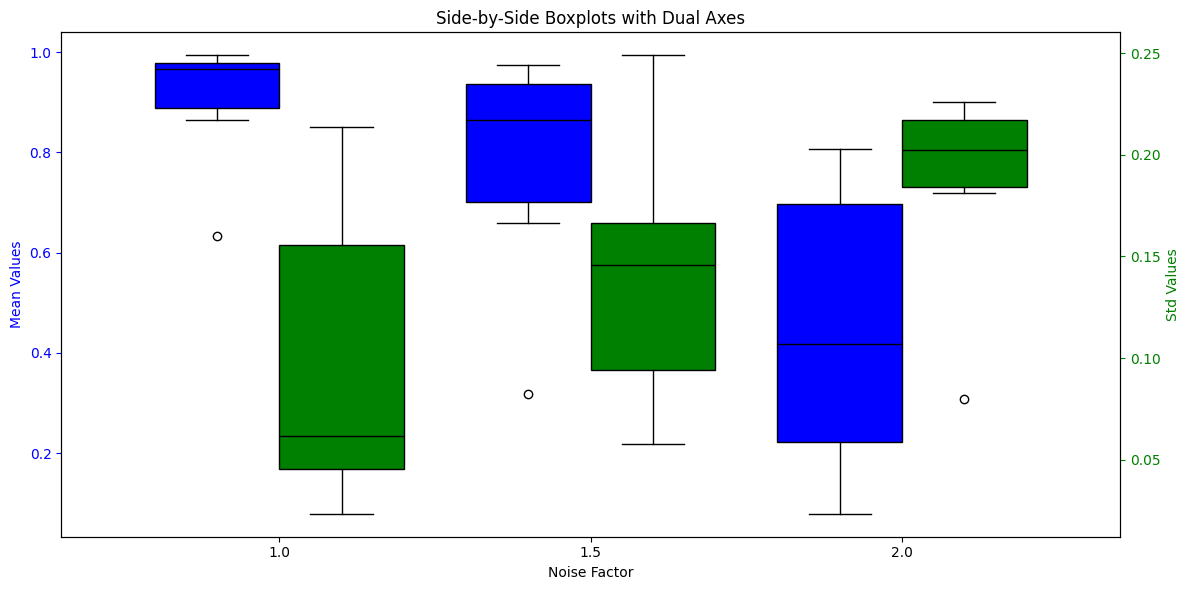

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Melt the dataframes for seaborn
mean_melted = mean_df.melt(id_vars=['Model', 'Noise Factor'], var_name='Metric', value_name='Mean')
std_melted = std_df.melt(id_vars=['Model', 'Noise Factor'], var_name='Metric', value_name='Std')

# Merge the mean and std dataframes
merged_df = pd.merge(mean_melted, std_melted, on=['Model', 'Noise Factor', 'Metric'])

# Filter for Meteor Score only
merged_df = merged_df[merged_df['Metric'] == 'Meteor Score']
noise_factors = sorted(merged_df['Noise Factor'].unique())

# Restructure the data for Mean and Std separately
mean_data = pd.DataFrame({'Noise Factor': merged_df['Noise Factor'], 'Value': merged_df['Mean']})
std_data = pd.DataFrame({'Noise Factor': merged_df['Noise Factor'], 'Value': merged_df['Std']})

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Define offsets for side-by-side boxplots
x_positions = np.arange(len(noise_factors))
bar_width = 0.4

# Plot the Mean boxplots on the primary y-axis
ax1.boxplot(
    [mean_data[mean_data['Noise Factor'] == nf]['Value'] for nf in noise_factors],
    positions=x_positions - bar_width / 2,
    widths=bar_width,
    patch_artist=True,
    boxprops=dict(facecolor='blue'),
    medianprops=dict(color='black')
)

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the Std boxplots on the secondary y-axis
ax2.boxplot(
    [std_data[std_data['Noise Factor'] == nf]['Value'] for nf in noise_factors],
    positions=x_positions + bar_width / 2,
    widths=bar_width,
    patch_artist=True,
    boxprops=dict(facecolor='green'),
    medianprops=dict(color='black')
)

# Customize the axes
ax1.set_xticks(x_positions)
ax1.set_xticklabels(noise_factors)
ax1.set_xlabel('Noise Factor')
ax1.set_ylabel('Mean Values', color='blue')
ax2.set_ylabel('Std Values', color='green')
ax1.set_title('Side-by-Side Boxplots with Dual Axes')

# Customize tick colors for clarity
ax1.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='green')

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()


In [19]:
# Separate data for each plot
def plot_accuracy(df, accuracy_type):
    plt.figure(figsize=(10, 6))
    for model in model_map.values():
        model_data = df[df['Model'] == model]
        plt.plot(model_data['Noise Factor'], model_data[accuracy_type], marker='o', label=model)
        # print model, nf, accuracy_type, accuracy
        print(f"Base Model: Phone, Model: {model}, NF: {model_data['Noise Factor'].values}, {accuracy_type}: {model_data[accuracy_type].values}")

    plt.xlabel('Noise Factor', fontweight='bold')
    plt.ylabel(f'{accuracy_type}', fontweight='bold')
    plt.title(f'Phone Model', fontweight='bold') # (alpha={ALPHA})
    
    # Bold tick numbers
    # plt.xticks(fontweight='bold')
    # plt.yticks(fontweight='bold')
    
    plt.legend()
    plt.savefig(f'{accuracy_type.replace(' ', '_').replace('-', '_')}_phone.pdf', format='pdf')
    plt.show()

In [20]:
# Plot Levenshtein Accuracy
# plot_accuracy(results_df, 'Levenshtein Accuracy')

# Plot BLEU Accuracy
# plot_accuracy(results_df, 'BLEU Accuracy')

# Plot Combined Accuracy
# plot_accuracy(results_df, 'Adjusted Accuracy')

# Plot Meteor Score
# plot_accuracy(results_df, 'Meteor Score')

# Plot Rouge-1
# plot_accuracy(results_df, 'Rouge-1')

# Plot Rouge-2
# plot_accuracy(results_df, 'Rouge-2')

# Plot Rouge-L
# plot_accuracy(results_df, 'Rouge-L')